In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Path to your file in Google Drive
file_path = '/content/drive/MyDrive/stock_price.csv'  # Change this to your file's location

# Load the CSV file into a pandas DataFrame
import pandas as pd

df = pd.read_csv(file_path)

# Renaming the columns from Japanese to English
df.columns = ['Date', 'Close Price', 'Open Price', 'High Price', 'Low Price', 'Volume', 'Change %']

# Function to clean 'Volume' column (handling M, K, B suffixes)
def clean_volume(volume):
    if isinstance(volume, str):
        if 'M' in volume:
            return float(volume.replace('M', '')) * 1e6
        elif 'K' in volume:
            return float(volume.replace('K', '')) * 1e3
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1e9
        elif volume == '--':  # Handle missing values like '--'
            return None
    try:
        return float(volume)  # For values like '400'
    except ValueError:
        return None  # Handle any unexpected non-numeric values

# Function to clean 'Change %' column (remove '%' and convert to float)
def clean_change(change):
    if isinstance(change, str):
        return float(change.replace('%', ''))
    try:
        return float(change)
    except ValueError:
        return None

# Apply cleaning functions to relevant columns
df['Volume'] = df['Volume'].apply(clean_volume)
df['Change %'] = df['Change %'].apply(clean_change)

# Handle missing values (fill or remove, depending on your needs)
df.fillna(0, inplace=True)  # This will replace NaN with 0

# Save the cleaned DataFrame to a new CSV file with English headers
output_file = '/content/drive/MyDrive/cleaned_stock_price.csv'  # Change this to your desired output location in Drive
df.to_csv(output_file, index=False)

print(f'File converted and cleaned, saved as {output_file}')


File converted and cleaned, saved as /content/drive/MyDrive/cleaned_stock_price.csv


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA

# Load the stock data
df = pd.read_csv('/content/drive/MyDrive/cleaned_stock_price.csv')

# Display the first few rows of the dataset
print(df.head())


         Date  Close Price  Open Price  High Price  Low Price       Volume  \
0  2024-08-01        156.3       159.3       159.4      156.1   79150000.0   
1  2024-07-31        160.4       158.2       160.7      158.1  173910000.0   
2  2024-07-30        158.7       158.8       159.2      158.0  138140000.0   
3  2024-07-29        159.7       158.7       160.2      158.4  126280000.0   
4  2024-07-26        157.9       159.3       159.6      157.9  155080000.0   

   Change %  
0     -2.56  
1      1.07  
2     -0.63  
3      1.14  
4     -0.13  


Date           0
Close Price    0
Open Price     0
High Price     0
Low Price      0
Volume         0
Change %       0
dtype: int64


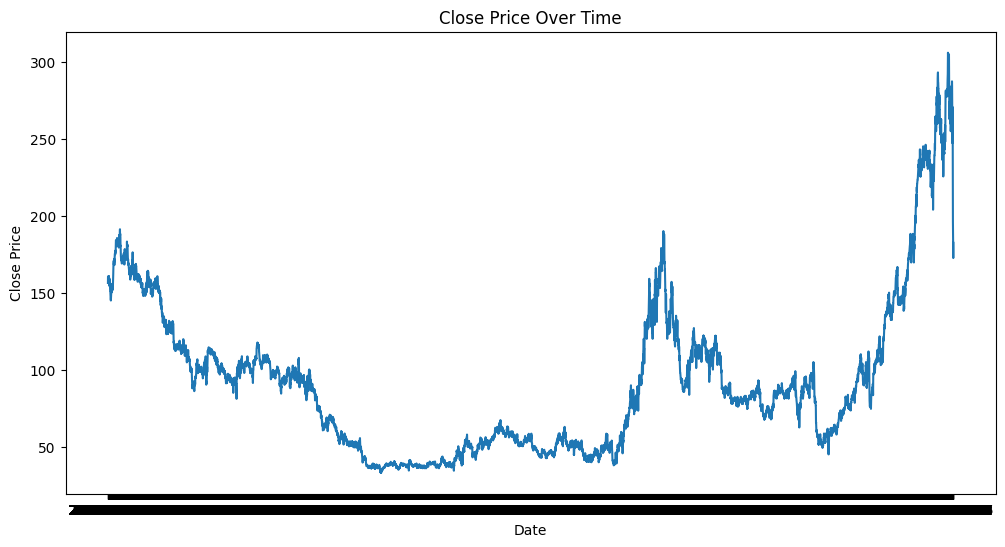

       Close Price   Open Price   High Price    Low Price        Volume  \
count  9202.000000  9202.000000  9202.000000  9202.000000  9.202000e+03   
mean     92.180961    92.256183    93.176451    91.330146  1.726677e+08   
std      50.452228    50.598215    51.049837    50.087405  1.251280e+08   
min      33.000000    33.000000    33.200000    32.200000  9.340000e+06   
25%      52.000000    52.100000    52.800000    51.500000  8.073000e+07   
50%      85.100000    85.100000    86.050000    84.200000  1.540150e+08   
75%     110.800000   110.800000   111.900000   109.275000  2.305225e+08   
max     305.900000   309.800000   311.800000   303.900000  1.280000e+09   

          Change %  
count  9202.000000  
mean      0.017502  
std       1.876667  
min     -14.740000  
25%      -0.940000  
50%       0.000000  
75%       0.900000  
max      16.250000  


In [5]:
# Check for missing values
print(df.isnull().sum())

# Plot the Close Price to visualize trends over time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close Price'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Calculate basic statistics
print(df.describe())


In [6]:
# Convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date
df.sort_values('Date', inplace=True)

# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

# Create lag features
df['Prev_Close'] = df['Close Price'].shift(1)
df['Prev_Close'].fillna(method='bfill', inplace=True)

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Close Price', 'Prev_Close']])

# Train-test split
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
train_dates, test_dates = df['Date'][:train_size], df['Date'][train_size:]


<ipython-input-6-b7829158dfc9>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-6-b7829158dfc9>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Prev_Close'].fillna(method='bfill', inplace=True)
<ipython-input-6-b7829158dfc9>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Prev_Close'

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

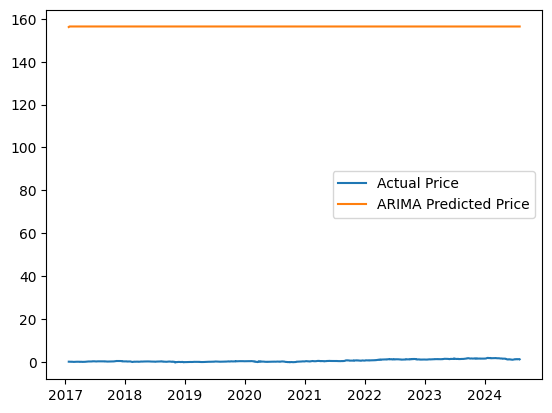

In [7]:
# Fit an ARIMA model
model = ARIMA(df['Close Price'], order=(5,1,0))
arima_result = model.fit()

# Forecast future prices
forecast = arima_result.forecast(steps=len(test_data))
plt.plot(test_dates, test_data[:, 0], label='Actual Price')
plt.plot(test_dates, forecast, label='ARIMA Predicted Price')
plt.legend()
plt.show()



Epoch 1/20


<ipython-input-12-a81b7b359ed8>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - loss: 0.1132
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 0.0062
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - loss: 0.0056
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - loss: 0.0054
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - loss: 0.0048
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - loss: 0.0046
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - loss: 0.0042
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - loss: 0.0038
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - loss: 0.0038
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 0.0038
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 0.0035
Epoch 12/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 0.0032
Epoch 13/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 0.0034
Epoch 14/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.0029
Epoch 15/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step 

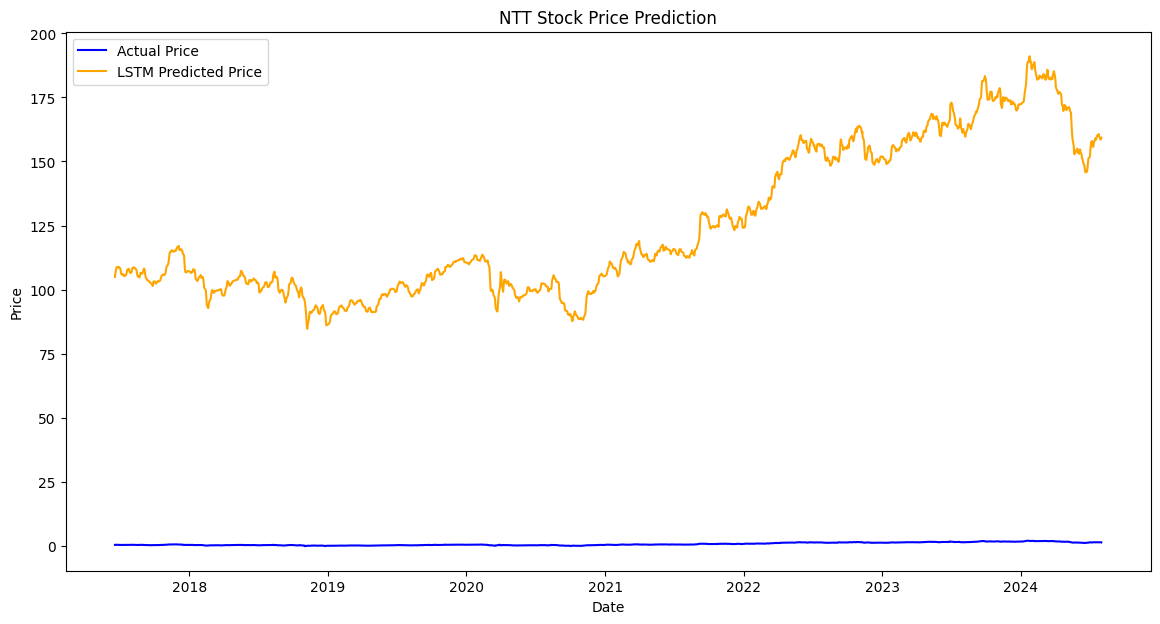

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/cleaned_stock_price.csv')

# Convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date
df.sort_values('Date', inplace=True)

# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

# Scaling only the Close Price
scaler = StandardScaler()
scaled_close_prices = scaler.fit_transform(df[['Close Price']])  # Only scale 'Close Price'

# Train-test split
train_size = int(len(scaled_close_prices) * 0.8)
train_data, test_data = scaled_close_prices[:train_size], scaled_close_prices[train_size:]
train_dates, test_dates = df['Date'][:train_size], df['Date'][train_size:]

# Prepare the data for LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=84, epochs=20)

# Make predictions
lstm_predictions = model.predict(X_test)

# Inverse transform predictions back to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Plot the predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(test_dates[time_step+1:], test_data[time_step+1:, 0], label='Actual Price', color='blue')
plt.plot(test_dates[time_step+1:], lstm_predictions, label='LSTM Predicted Price', color='orange')
plt.title('NTT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [13]:
# Evaluate ARIMA model
from sklearn.metrics import mean_squared_error

mse_arima = mean_squared_error(test_data[:, 0], forecast)
print(f'ARIMA Mean Squared Error: {mse_arima}')

# Evaluate LSTM model
mse_lstm = mean_squared_error(test_data[time_step+1:, 0], lstm_predictions)
print(f'LSTM Mean Squared Error: {mse_lstm}')


ARIMA Mean Squared Error: 24265.764565456593
LSTM Mean Squared Error: 16283.0972063657


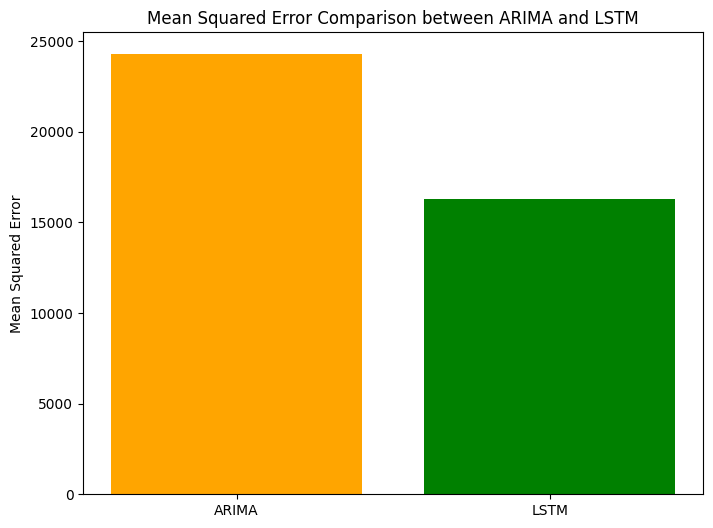

In [15]:
# Bar plot for MSE comparison
plt.figure(figsize=(8,6))
models = ['ARIMA', 'LSTM']
mse_values = [mse_arima, mse_lstm]

plt.bar(models, mse_values, color=['orange', 'green'])
plt.title('Mean Squared Error Comparison between ARIMA and LSTM')
plt.ylabel('Mean Squared Error')
plt.show()
